<a href="https://colab.research.google.com/github/Gabriel-Esteves-0404/BASECODE/blob/main/BASECOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pennylane

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane import math


#importações necessárias para o circuito da biblioteca Pennylane

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
n_qubits = 4
dev = qml.device("lightning.qubit", wires=n_qubits)


#definição do números de qubits e do modo que esse circuito será executado "default"

In [4]:
def ansatz(params, x=None):
    for layer in range(params.shape[0]):
        # Codificação de 4 features
        qml.RX(x[0], wires=0)
        qml.RX(x[1], wires=1)
        qml.RY(x[2], wires=2)
        qml.RY(x[3], wires=3)

        for i in range(n_qubits):
          qml.RY(params[layer][i][0], wires=i)
          qml.RZ(params[layer][i][1], wires=i)
          qml.RY(params[layer][i][2], wires=i)
          qml.RZ(params[layer][i][3], wires=i)


        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[1, 0])
        qml.CNOT(wires=[3, 2])




In [5]:

@qml.qnode(dev) #Esse decador (@) transforma esse circuit em um circuito quantico do pennylane
#faz simulações, está usando (dev) porque vai incrementar as propriedades do dev no circuit definido abaixo

def circuit(params, x=None): #Aqui é definido o circuit, em que é construido atráves do Ansatz
    ansatz(params,x)  # Codifica as features nas rotações RX
    return qml.expval(qml.PauliZ(0))


#aqui retorna o VEM pelo PauliZ do primeiro qubit


In [6]:
#aqui iremos implementar o (X,Y,x,y) que serão:
# X(todos os valores de entrada do dataset)
# Y(todos os valores de saida esperada // labels ou rótulo)
# x(valor de entrada de cada dado)
# y(valor de saida esperado de cada dado)


# 👇 Função auxiliar: Binary Cross Entropy
def binary_cross_entropy(pred, y):
    eps = 1e-10
    pred = (pred + 1) / 2  # mapeia saída de [-1, 1] para [0, 1]
    return - (y * np.log(pred + eps) + (1 - y) * np.log(1 - pred + eps))

# 👇 Função principal: custo médio
def cost(params, X, Y):
    loss = 0
    for x, y in zip(X, Y):
        pred = circuit(params, x)
        loss += binary_cross_entropy(pred, y)
    return loss / len(X)


In [7]:
def accuracy(params, X, Y):
    correct = 0
    for x, y in zip(X, Y):
        pred = circuit(params, x)

        pred_label = 1 if pred >= 0 else 0
        if pred_label == y:
            correct += 1
    return correct / len(X)

In [8]:
!git clone https://github.com/Gabriel-Esteves-0404/BASECODE.git
%cd BASECODE/DATASET
base_path = "./"

fatal: destination path 'BASECODE' already exists and is not an empty directory.
/content/BASECODE/DATASET


In [9]:
          #Importação do Dataset (COVID / Normal)

import os
from PIL import Image

size = (64, 64)
# classifica uma dimensão de imagem

def process_image(path):
     img = Image.open(path).convert("L").resize((64, 64))
     return np.array(img) / 255.0
# Nessa parte se define o process_image, em que vai abrir o arquivo inserido na pasta
# pré-definida, a transforma em escala de cinza dimensiona para o valor definido em size
# Normaliza os pixels no intervalo de [0,1]


X = [] #Array dos dados de entradas
y = [] #Array dos labels (rótulos)

# COVID

covid_img_files = sorted(os.listdir(os.path.join(base_path, "COVID_IMAGES")))
covid_mask_files = sorted(os.listdir(os.path.join(base_path, "COVID_MASK")))


for img_file, mask_file in zip(covid_img_files, covid_mask_files):
    img = process_image(os.path.join(base_path, "COVID_IMAGES", img_file))
    mask = process_image(os.path.join(base_path, "COVID_MASK", mask_file))
    img_masked = img * mask
    X.append(img_masked.flatten())
    y.append(1)
# Classificar os dados do COVID juntando a images com os masks (imagens mascaradas)
# dentro da lista X, transforma os dados de entrada de 64x64 px por um vetor de 4096 D
# Defini o COVID como label 1

# NORMAL
normal_img_files = sorted(os.listdir(os.path.join(base_path, "NORMAL_IMAGES")))
normal_mask_files = sorted(os.listdir(os.path.join(base_path, "NORMAL_MASK")))


for img_file, mask_file in zip(normal_img_files, normal_mask_files):
    img = process_image(os.path.join(base_path, "NORMAL_IMAGES", img_file))
    mask = process_image(os.path.join(base_path, "NORMAL_MASK", mask_file))
    img_masked = img * mask
    X.append(img_masked.flatten())
    y.append(0)
# Classificar os dados do Normal juntando a images com os masks (imagens mascaradas)
# dentro da lista X, transforma os dados de entrada de 64x64 px por um vetor de 4096 D
# Defini o Normal como label 0

X = np.array(X)
y = np.array(y)
# Transforma a lista em array do numpy

print("Formato de X:", X.shape) #dados de entrada (10,4096) 10 vetores de 4096D
print("Formato de y:", y.shape) # 10 labels binários
# Checar formato


Formato de X: (400, 4096)
Formato de y: (400,)


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=4)
# Aqui PCA entende que terá que redimensionar o vetor em 4 componentes

X_reduced = pca.fit_transform(X)

scaler = StandardScaler()
X_reduced = scaler.fit_transform(X_reduced)
X_reduced *= np.pi
#Analisa os features e transforma os vetores de 4096D em apenas apenas 4 componentes
# na qual se destaca as principais informações do dado


# Verificações
print("X_reduced shape:", X_reduced.shape)


X_reduced shape: (400, 4)


In [11]:
# Reduzir dataset para 50 imagens por classe (100 no total)
X_reduced_small = []
y_small = []

for label in [0, 1]:
    idx = np.where(y == label)[0][:50]
    X_reduced_small.extend(X_reduced[idx])
    y_small.extend(y[idx])

X_reduced_small = np.array(X_reduced_small)
y_small = np.array(y_small)

# Atualiza X e y para os reduzidos
X = X_reduced_small
y = y_small


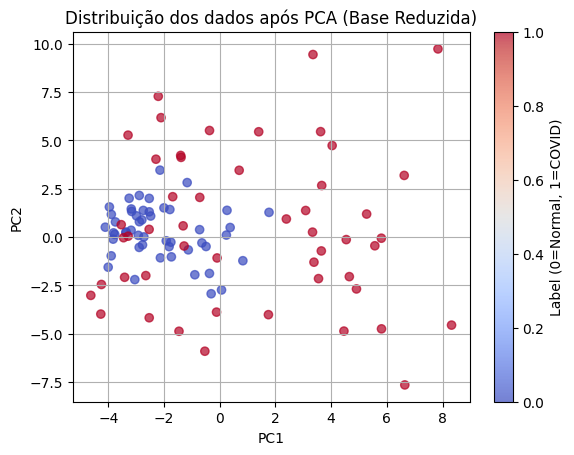

In [12]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", alpha=0.7)
plt.title("Distribuição dos dados após PCA (Base Reduzida)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Label (0=Normal, 1=COVID)")
plt.grid(True)
plt.show()



In [13]:
from sklearn.model_selection import train_test_split

# Divide em 80% treino e 20% validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [14]:
n_qubits = 4
n_layers = 5
param_shape = (n_layers, n_qubits, 4)  # 2 ângulos por qubit: RY e RZ
params = np.random.uniform(0, np.pi, size=param_shape, requires_grad=True)


In [15]:
from pennylane.optimize import AdamOptimizer

opt = AdamOptimizer(stepsize=0.001)  # ou stepsize=0.05, se quiser testar


 # ou stepsize=0.05, se quiser testar


# stepsize define o quanto o parametro será ajustado em cada interação
# quanto maior o stepsize: será ajustado forte o parametro, pode passar do mínimo e ficar oscilando
# quanto menor: demora mais para se chegar ao mínimo, mas tem mais estabilidade

In [16]:
loss_history = []

steps = 600
batch_size = 10

for step in range(steps):
    indices = np.random.choice(len(X_train), batch_size, replace=False)
    X_batch = X_train[indices]
    y_batch = y_train[indices]

    params = opt.step(lambda v: cost(v, X_batch, y_batch), params)

    loss = cost(params, X_batch, y_batch)
    loss_history.append(loss)

    if step % 50 == 0:
      sample_preds = [circuit(params, x) for x in X_val[:5]]
      print("Sample preds:", np.round(sample_preds, 3))


    if step % 50 == 0:
        acc = accuracy(params, X_val, y_val)
        print(f"Step {step}: Accuracy validação = {acc:.2%} | Cost batch = {cost(params, X_batch, y_batch):.4f}")


    if step % 50 == 0:
        acc_train = accuracy(params, X_train, y_train)
        acc_val = accuracy(params, X_val, y_val)
        print(f"Step {step}: Acc Treino = {acc_train:.2%} | Acc Validação = {acc_val:.2%} | Cost batch = {loss:.4f}")



Sample preds: [-0.274  0.255 -0.124  0.62   0.141]
Step 0: Accuracy validação = 50.00% | Cost batch = 0.7284
Step 0: Acc Treino = 52.50% | Acc Validação = 50.00% | Cost batch = 0.7284
Sample preds: [-0.264  0.353 -0.081  0.507  0.023]
Step 50: Accuracy validação = 55.00% | Cost batch = 0.6694
Step 50: Acc Treino = 55.00% | Acc Validação = 55.00% | Cost batch = 0.6694
Sample preds: [-0.251  0.406 -0.035  0.359 -0.099]
Step 100: Accuracy validação = 60.00% | Cost batch = 0.7869
Step 100: Acc Treino = 52.50% | Acc Validação = 60.00% | Cost batch = 0.7869
Sample preds: [-0.245  0.412  0.037  0.316 -0.154]
Step 150: Accuracy validação = 65.00% | Cost batch = 0.7682
Step 150: Acc Treino = 58.75% | Acc Validação = 65.00% | Cost batch = 0.7682
Sample preds: [-0.281  0.429  0.086  0.214 -0.195]
Step 200: Accuracy validação = 65.00% | Cost batch = 1.0509
Step 200: Acc Treino = 58.75% | Acc Validação = 65.00% | Cost batch = 1.0509
Sample preds: [-0.332  0.369  0.132  0.123 -0.232]
Step 250: Accur

KeyboardInterrupt: 

In [ ]:
import pennylane as qml
import matplotlib.pyplot as plt

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def visual_ansatz():
    x = [qml.numpy.pi/4]*4  # valores de entrada simbólicos

    for layer in range(4):  # 4 camadas
        qml.RX(x[0], wires=0)
        qml.RX(x[1], wires=1)
        qml.RY(x[2], wires=0)
        qml.RY(x[3], wires=1)

        qml.RY(layer + 0.1, wires=0)
        qml.RZ(layer + 0.2, wires=0)
        qml.RY(layer + 0.3, wires=1)
        qml.RZ(layer + 0.4, wires=1)

        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 0])

    return qml.expval(qml.PauliZ(0))

fig, ax = qml.draw_mpl(visual_ansatz)()
fig.suptitle("Circuito do Ansatz Customizado", fontsize=14)
fig.savefig("ansatz_circuito.png")  # Arquivo salvo localmente


In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(loss_history, marker='o')
plt.title("Evolução da Loss durante o Treinamento")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
print(f"Parâmetros finais: {params}")
#parametros finais que utilizam os operadores RY e RX

In [ ]:
from pennylane import draw

# desenha o QNode completo (ansatz + codificação + medição)
drawer = draw(circuit)
print(drawer(params, X_train[0]))
